In [2]:
import numpy as np
import pandas as pd 

In [3]:
from typing import List
import csv

def parse_species_list(species_file: str, delim='\n') -> List[str]:
    with open(species_file, 'r') as f:
         species_list = [name for lst in csv.reader(f, delimiter=delim) 
                         for name in lst]          
    
    return species_list

In [4]:
# I/O

species_relative_abundance_file = "./input/species_relative_abundances.csv"
full_data = "./input/4347_final_relative_abundances.txt"
MH_species_file = "./input/MH_species.txt"
MN_species_file = "./input/MN_species.txt"
output_file = 'GMHI_output.csv'
control = './input/control.csv'

## Overall Steps
1. Run MetaPhlAn2 on a stool metagenome using '--tax_lev s' argument.
2. Merge outputs using 'merge_metaphlan_tables.py' script provided in the MetaPhlAn2 pipeline (see MetaPhlAn2's online tutorial).
3. Make sure of the following: The merged species' relative abundance profile should be arranged as shown in 'species_relative_abundances.csv'. Accordingly, the first column should contain names of the species-level clades (i.e., taxonomic names with 's__' flag). Subsequent columns should contain the species' relative abundances corresponding to each metagenome sample.
4. Save input data from Step-3 as a '.csv' file, and run the following script to calculate GMHI for each stool metagenome. GMHI values for each sample in 'species_relative_abundances.csv' are shown in 'GMHI_output.csv'.

In [85]:
tmp1 = pd.read_csv(full_data, sep = "\t",
                   header = 0, index_col = 0)

In [86]:
# Removing unclassified and virus species - skipped transposing steps
na_species = tmp1.index.str.contains('unclassified|virus', regex=True)
species_profile_2 = tmp1[~na_species]

In [87]:
# Re-normalization of species' relative abundances after removing unclassified and virus species
species_profile_3 = species_profile_2.apply(lambda x: x/x.sum(), axis=0)
species_profile_3[species_profile_3 < 0.00001] = 0

In [88]:
MH_species = parse_species_list(MH_species_file) # Health-prevalent species (7 in total)
MN_species = parse_species_list(MN_species_file) # Health-scarce species (43 in total)

# Extracting Health-prevalent species present in metagenome
MH_species_metagenome = species_profile_3[species_profile_3.index.isin(MH_species)]
# Extracting Health-scarce species present in metagenome
MN_species_metagenome = species_profile_3[species_profile_3.index.isin(MN_species)]

In [89]:
# Shannon index - alpha diversity
MH_not_zero = MH_species_metagenome[MH_species_metagenome > 0]
MN_not_zero = MN_species_metagenome[MN_species_metagenome > 0]
alpha = lambda x: -1 * np.sum(np.log(x) * x)
MH_shannon = MH_not_zero.apply(alpha, axis=0)
MN_shannon = MN_not_zero.apply(alpha, axis=0)

In [90]:
# Richness of Health-prevalent species
R_MH = MH_not_zero.count()
# Richness of Health-scarce species
R_MN = MN_not_zero.count()

### Original values


In [91]:
constant = R_MH.rename('h').to_frame().join(R_MN.rename('n').to_frame())

In [99]:
import re
# searching for healthy samples in dataset 
healthy_mask = tmp1.columns.str.contains('healthy', flags=re.I, regex=True)

# calculating healthy and non-healthy samples
n_healthy = healthy_mask.sum()
n_non_healthy = len(tmp1.columns) - n_healthy

# calculating kh and kn
n = 1 # kh and kn are 1% of all healthy and non-healthy samples respectively
kh = int(n_healthy*(n/100))
kn = int(n_non_healthy*(n/100))

#Median RMH from 1% of the top-ranked samples (see Methods)
HC1 = constant.sort_values(by=['h', 'n'], ascending=[False, True])
MH_prime = np.median(HC1[:kh]['h'])

#Median RMN from 1% of the bottom-ranked samples (see Methods)
NHC1 = constant.sort_values(by=['h', 'n'], ascending=[True, False])
MN_prime = np.median(NHC1[:kn]['n'])

In [100]:
# Collective abundance of Health-prevalent species
# Collective abundance of Health-scarce species

psi_MH = (R_MH / MH_prime) * MH_shannon 
psi_MN = (R_MN / MN_prime) * MN_shannon
index = np.log10((psi_MH + 0.00001) / (psi_MN + 0.00001))  # 0.00001 added to avoid having the denominator as 0

In [101]:
GMHI = pd.DataFrame(index, columns=['GMHI'])

In [102]:
GMHI['Type'] = GMHI.index.str.split("_", expand=True)
GMHI['Type'] = GMHI.Type.apply(lambda x: x[0])

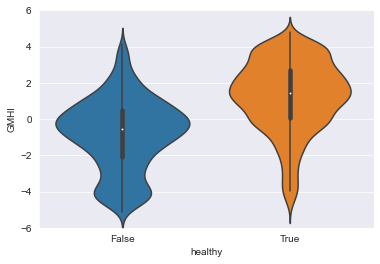

In [103]:
GMHI['healthy'] = GMHI.Type == 'Healthy'

import seaborn as sns

sns.set_style('darkgrid')
g = sns.violinplot(x='healthy', y='GMHI', data=GMHI)
g.set(ylim=(-6, 6));

In [104]:
GMHI.describe()

,GMHI
count,4347.000000
mean,0.435311
std,2.226649
min,-5.128125
25%,-0.864572
50%,0.586145
75%,2.063562
max,4.815488


In [105]:
GMHI.to_csv(output_file)